# Start Pooling

# Start Pooling

In [ ]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib
import simulate_multi_cty_bond as smcb



In [ ]:
bond_cache = {}

def get_bond_metrics(pool, pay_dam_pool_it, nominal_pool_it):
    pool_key = tuple(sorted(pool))  # Create a unique key for the pool
    if pool_key not in bond_cache:
        # If result isn't cached, compute and store it
        pay_dam_temp = {c: pay_dam_pool_it[c] for c in pool}
        nominal_temp = {c: nominal_pool_it[c] for c in pool}
        bond_metrics, returns, tot_coverage, premium_dic, nominal, es_metrics, MES_cty = bond_fct.mlt_cty_bond(
            countries=pool,
            pay_dam_df_dic=pay_dam_temp,
            nominals_dic=nominal_temp,
            opt_cap=True,
        )
        bond_cache[pool_key] = {
            "Returns": returns
            }
    return bond_cache[pool_key]

## Define Countries and Variables for Cat Bond Development

In [ ]:
#choose country
countries = [212, 670, 308, 659, 662, 882, 174, 548]
countries_150 = [548]
countries_30 = [212, 670, 308, 659, 662, 882, 174]
#minimum damage to be protected per grid cell calculated using return period
lower_rp = 100

#number of simulated years
r = 10000

#set risk free rate, either single value or array
rf_rates = 0.00


#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd
#set risk muliplier reported by artems
artemis_multiplier = 4.11

#set sharpe ratio to beat
target_sharpe = 0.5

prot_share = 0.008
lower_share = 0.045
prot_rp = 250
lower_rp = 30

## Designe Single Country Bonds
### Define Cat Bond function

### Design Cat Bond for Country 1

In [ ]:
bond_metrics_sng_dic = {}
returns_sng_dic = {}
premium_dic_sng_dic = {}
nominal_sng_dic = {}
pay_dam_df_sng_dic = {}
es_metrics_sng_dic = {}
int_grid_sng_dic = {}
imp_per_event_flt_sng_dic = {}
imp_admin_evt_flt_sng_dic = {}

for cty in countries:
    if cty in bond_metrics_sng_dic:
        print(f"Bond for {cty} already calculated, skipping.")
        continue
    print(f'Create bond for {cty}')
    if cty in countries_150:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                    prot_rp=prot_rp, 
                                                                                                                                                    to_prot_share=lower_share,
                                                                                                                                                    buffer_distance_km=105,
                                                                                                                                                    res_exp=150,
                                                                                                                                                    grid_size=1000,
                                                                                                                                                    buffer_grid_size=3,
                                                                                                                                                    incl_plots=False)
    if cty in countries_30:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                    prot_rp=prot_rp, 
                                                                                                                                                    to_prot_share=lower_share,
                                                                                                                                                    buffer_distance_km=105,
                                                                                                                                                    res_exp=30,
                                                                                                                                                    grid_size=1000,
                                                                                                                                                    buffer_grid_size=3,
                                                                                                                                                    incl_plots=False)
    bond_metrics_sng_dic[cty] = bond_metrics
    returns_sng_dic[cty] = returns
    premium_dic_sng_dic[cty] = premium_dic
    nominal_sng_dic[cty] = nominal
    pay_dam_df_sng_dic[cty] = pay_dam_df
    es_metrics_sng_dic[cty] = es_metrics
    int_grid_sng_dic[cty] = int_grid
    imp_per_event_flt_sng_dic[cty] = imp_per_event_flt
    imp_admin_evt_flt_sng_dic[cty] = imp_admin_evt_flt

## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

### Create Multi-Country bond

In [587]:
tranches_array = np.array([20, 500])

nominal_dic = {}
pay_dam_df_dic = {}
for cty in countries:
    nominal_dic[cty] = nominal_sng_dic[cty]
    pay_dam_df_dic[cty] = pay_dam_df_sng_dic[cty]
    
ncf_pool, premiums_pool, premium_dic_pool, nominal_pool, es_metrics_pool, MES_cty_pool, tranches = bond_fct.mlt_cty_bond(countries=countries,pay_dam_df_dic=pay_dam_df_dic,nominals_dic=nominal_dic, tranches_array=tranches_array, opt_cap=True)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranch_df['Capital requ.'] = tranch_df['Capital requ.']


In [569]:
nominal_sng = 0
for i in nominal_dic:
    nominal_sng += nominal_dic[i]

print(nominal_pool, nominal_sng)

1655553262.3270187 2322865462.4438457


In [570]:
sng_ann_ret = {}
pool_sng_ann_ret = {}
for cty in countries:
    sng_ann_ret[cty] = returns_sng_dic[cty]['Annual'][0] 
for key in ncf_pool:
    if key != 'Total':
        pool_sng_ann_ret[key] = ncf_pool[key] / tranches.loc[tranches['RP'] == key, 'nominal'].iloc[0]


pool_ann_ret = ncf_pool['Total']

In [571]:
df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
df_returns_pool = pd.DataFrame({f"{country} Returns": returns for country, returns in pool_sng_ann_ret.items()})

r = np.mean(df_returns,axis=0)
r_pool= np.mean(df_returns_pool,axis=0)

# Create a covariance matrix
covar = df_returns.cov()
covar_pool = df_returns_pool.cov()

In [572]:
r_pool

20 Returns     0.092434
500 Returns    0.046134
Max Returns    0.041022
dtype: float64

In [573]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df_returns.columns)

p_ret_pool = [] # Define an empty array for portfolio returns
p_vol_pool = [] # Define an empty array for portfolio volatility
p_weights_pool = [] # Define an empty array for asset weights

num_assets_pool = len(df_returns_pool.columns)

num_portfolios = 10000  # Number of portfolios to simulate
alpha = 0.5

In [574]:
from numpy.random import dirichlet

for _ in range(num_portfolios):
    weights = dirichlet([alpha] * num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, r) 
    p_ret.append(returns)
    var = covar.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # yearly standard deviation
    p_vol.append(sd)    

    weights_pool = dirichlet([alpha] * num_assets_pool)
    weights_pool = weights_pool/np.sum(weights_pool)
    p_weights_pool.append(weights_pool)
    returns_pool = np.dot(weights_pool, r_pool) 
    p_ret_pool.append(returns_pool)
    var_pool = covar_pool.mul(weights_pool, axis=0).mul(weights_pool, axis=1).sum().sum()# Portfolio Variance
    sd_pool = np.sqrt(var_pool) # yearly standard deviation
    p_vol_pool.append(sd_pool)

In [575]:
data = {'Returns':p_ret, 'Volatility':p_vol, 'Sharpe Ratio':np.array(p_ret)/np.array(p_vol)}
data_pool = {'Returns':p_ret_pool, 'Volatility':p_vol_pool, 'Sharpe Ratio':np.array(p_ret_pool)/np.array(p_vol_pool)}

for counter, symbol in enumerate(df_returns.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

for counter, symbol in enumerate(df_returns_pool.columns.tolist()):
    data_pool[symbol+' weight'] = [w[counter] for w in p_weights_pool]

In [576]:
portfolios  = pd.DataFrame(data)
max_sharpe_idx = portfolios['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolios.loc[max_sharpe_idx]
portfolios.head() # Dataframe of the 10000 portfolios created


portfolios_pool  = pd.DataFrame(data_pool)
max_sharpe_idx_pool = portfolios_pool['Sharpe Ratio'].idxmax()
max_sharpe_portfolio_pool = portfolios_pool.loc[max_sharpe_idx_pool]

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt

# Expected returns and covariance matrices
r = np.mean(df_returns, axis=0)  # Expected returns for df_returns
r_pool = np.mean(df_returns_pool, axis=0)  # Expected returns for df_returns_pool

covar = df_returns.cov()  # Covariance matrix for df_returns
covar_pool = df_returns_pool.cov()  # Covariance matrix for df_returns_pool

# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
    return np.sum(weights * mean_returns)

# Function for optimization: minimize risk for a given return
def minimize_risk(target_return, mean_returns, cov_matrix):
    # Number of assets in the portfolio
    num_assets = len(mean_returns)
    
    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = ({
        'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
    }, {
        'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
    })
    
    # Initial guess: equal weights
    initial_guess = np.ones(num_assets) / num_assets
    
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    # Minimize risk (objective function)
    result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x, result.fun  # Return the optimized weights and the minimized risk

# Generate a series of target returns and corresponding risks
target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
risks = []

for target_return in target_returns:
    weights, risk = minimize_risk(target_return, r, covar)
    risks.append(risk)

## Repeat for the second data set (df_returns_pool)
risks_pool = []
target_returns_pool = np.linspace(np.min(r_pool), np.max(r_pool), 50)
for target_return in target_returns_pool:
    weights, risk = minimize_risk(target_return, r_pool, covar_pool)
    risks_pool.append(risk)


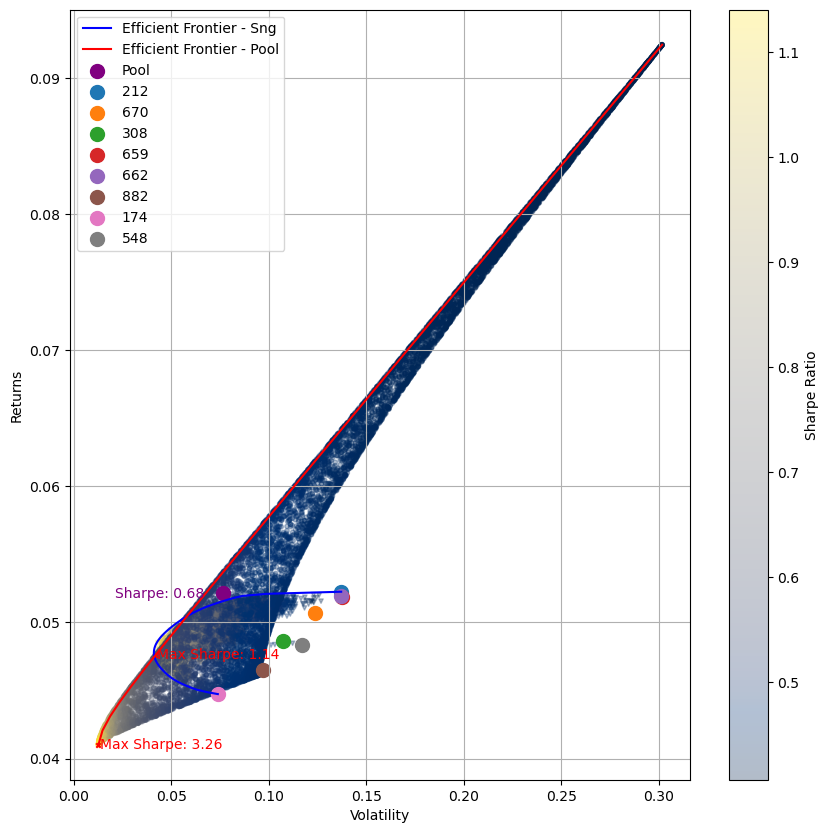

In [617]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', cmap='cividis', marker='v', s=10, alpha=0.3, grid=True, figsize=[10,10])
plt.text(max_sharpe_portfolio['Volatility'] + 0.001,max_sharpe_portfolio['Returns'],f"Max Sharpe: {max_sharpe_portfolio['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')
plt.plot(risks, target_returns, label="Efficient Frontier - Sng", color='blue')
plt.scatter(x=portfolios_pool['Volatility'], y=portfolios_pool['Returns'], c=portfolios_pool['Sharpe Ratio'], cmap='cividis', marker='o', s=10, alpha=0.3)
plt.text(max_sharpe_portfolio_pool['Volatility'] + 0.001,max_sharpe_portfolio_pool['Returns'],f"Max Sharpe: {max_sharpe_portfolio_pool['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')
plt.scatter(x=max_sharpe_portfolio_pool['Volatility'], y=max_sharpe_portfolio_pool['Returns'], color='red', marker='x', s=10, alpha=1.0)
plt.scatter(x=max_sharpe_portfolio['Volatility'], y=max_sharpe_portfolio['Returns'], color='red', marker='x', s=10, alpha=1.0)
plt.plot(risks_pool, target_returns_pool, label="Efficient Frontier - Pool", color='red')

# Plot pool point
plt.scatter(np.std(pool_ann_ret), np.mean(pool_ann_ret), label='Pool', color='purple', s=100)

# Add label for pool Sharpe ratio
plt.text(np.std(pool_ann_ret)-0.01,np.mean(pool_ann_ret),f'Sharpe: {np.mean(pool_ann_ret)/np.std(pool_ann_ret):.2f}',fontsize=10,ha='right',va='center',color='purple')

for cty in countries:
    plt.scatter(np.std(sng_ann_ret[cty]), np.mean(sng_ann_ret[cty]), label=cty, s=100)
plt.legend()

In [586]:
closest_index = (portfolios['Volatility'] - np.std(pool_ann_ret)).abs().idxmin()

# Extract the corresponding return
closest_return = portfolios.loc[closest_index, 'Returns']
closest_volatility = portfolios.loc[closest_index, 'Volatility']
print(np.mean(pool_ann_ret) - closest_return)
print(np.std(pool_ann_ret) - closest_volatility)


0.00124556603056699
-9.324029116020149e-07


c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


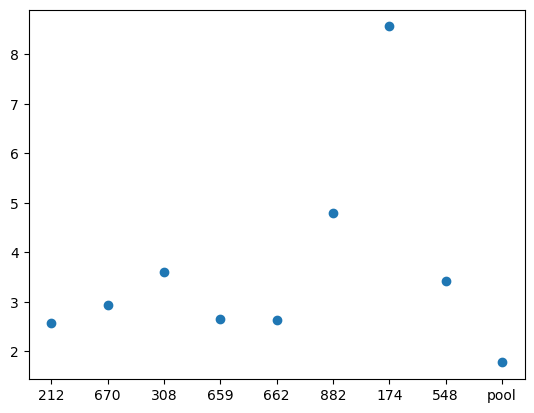

In [580]:
x = countries.copy()
x = [str(entry) for entry in x]
x.append('pool')
y = []
for cty in countries:
    y.append(bond_metrics_sng_dic[cty]['Total Premiums']/bond_metrics_sng_dic[cty]['Summed Payments'])
y.append(bond_metrics_pool['Total Premiums']/bond_metrics_pool['Summed Payments'])
plt.scatter(x,y)

In [581]:
s = []
n = []
for cty in countries:
    s.append(bond_metrics_sng_dic[cty]['Total Premiums'])
    n.append(nominal_sng_dic[cty])

print(bond_metrics_pool['Total Premiums'][0]/np.sum(s))
print(nominal_pool/np.sum(n))

0.0075090087288680685
0.7127202539682347
